In [1]:
# conda install statsmodels

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os # for fig save
from sklearn.linear_model import LinearRegression

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA

# Initial dataset overview and exploration

This dataset has data on the number of passengers transported by mode of transport in Ukraine, years 1995-2020
Source for dataset: https://www.kaggle.com/datasets/kseniakryvogubchenko/ua-passengers-1995-2020?resource=download

In [3]:
# import data set and check top rows
df = pd.read_csv('Data/ua_passengers_1995-2020.csv', sep=';')
df.head()

,year,railway,sea,river,auto_bus,air,tram,trolley,subway
0,1995,577431.5,7817.0,3594.1,3483173.0,1914.9,821652.3,1358736.9,561012.4
1,1996,538568.7,5044.6,2735.9,3304600.0,1724.0,788026.2,1590439.3,536304.1
2,1997,500838.8,4311.3,2443.1,2512147.2,1484.5,1265349.2,2388087.6,507897.0
3,1998,501428.7,3838.3,2356.5,2403424.6,1163.9,1450735.2,2717998.1,668456.4
4,1999,486810.4,3084.3,2269.4,2501707.5,1087.0,1456755.4,2735241.0,724425.5


In [4]:
# check general info about data base
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   year      26 non-null     int64  
 1   railway   26 non-null     float64
 2   sea       26 non-null     float64
 3   river     26 non-null     float64
 4   auto_bus  26 non-null     float64
 5   air       26 non-null     float64
 6   tram      26 non-null     float64
 7   trolley   26 non-null     float64
 8   subway    26 non-null     float64
dtypes: float64(8), int64(1)
memory usage: 2.0 KB


In [5]:
# check if have missing values
df.isnull().sum() 

year        0
railway     0
sea         0
river       0
auto_bus    0
air         0
tram        0
trolley     0
subway      0
dtype: int64

In [6]:
df.describe()

,year,railway,sea,river,auto_bus,air,tram,trolley,subway
count,26.000000,26.000000,26.000000,26.000000,2.600000e+01,26.000000,2.600000e+01,2.600000e+01,26.000000
mean,2007.500000,407824.500000,11857.934615,1546.111538,3.003374e+06,5156.550000,9.450878e+05,1.607972e+06,743352.684615
std,7.648529,126653.115605,15028.172028,894.806411,8.487019e+05,3572.125665,2.826577e+05,5.904788e+05,130840.813545
min,1995.000000,68332.500000,52.600000,256.500000,1.083873e+06,1087.000000,4.227532e+05,5.789996e+05,411149.700000
25%,2001.250000,398649.800000,4494.625000,604.925000,2.427995e+06,1804.350000,7.432981e+05,1.123551e+06,704022.650000
50%,2007.500000,445509.400000,6643.800000,1701.700000,3.183320e+06,4863.050000,8.106706e+05,1.469561e+06,752764.200000
75%,2013.750000,474513.125000,9213.050000,2207.450000,3.693202e+06,7246.925000,1.127235e+06,1.916250e+06,821579.550000
max,2020.000000,577431.500000,45836.000000,3594.100000,4.369126e+06,13705.800000,1.456755e+06,2.735241e+06,958693.900000


### Key Insights

- **Railway Passengers**: The average number of railway passengers is approximately **407,825**, with a maximum of **577,432**.
- **Sea Transport**: The passengers transported by sea average around **11,858**, with a maximum of **45,836**.
- **River Transport**: Average river transport numbers are relatively low, around **1,546** passengers, with a max of **3,594**.
- **Auto Bus Passengers**: Auto bus transport has the highest average, with about **3,003,374** and reaching a maximum of **4,369,126**.
- **Air Travel**: The average air passengers number around **5,157**, with a notable peak at **13,706**.
- **Trams, Trolleys, and Subways**: These modes show varied usage, with averages of **945,088**, **1,607,972**, and **743,353** respectively, reflecting urban transit patterns.

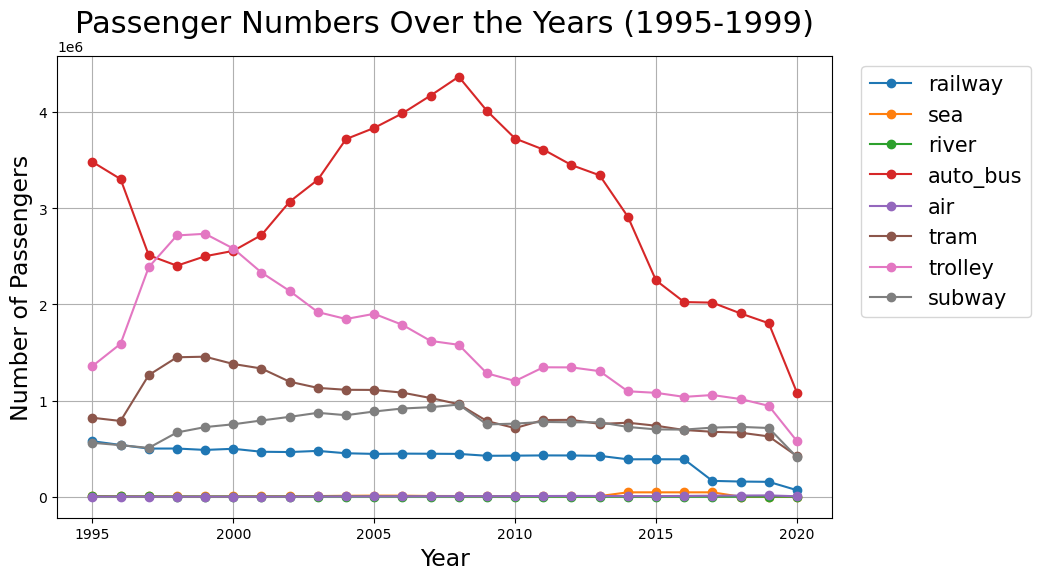

In [7]:
# Plotting the data
plt.figure(figsize=(10, 6))

# Plot each mode of transport
for column in df.columns[1:]:  # Skip the first column which is 'year'
    plt.plot(df['year'], df[column], marker='o', label=column)

# Adding titles and labels
plt.title('Passenger Numbers Over the Years (1995-1999)', fontsize=22)
plt.xlabel('Year', fontsize=17)
plt.ylabel('Number of Passengers', fontsize=17)
plt.xticks(df['year'][::5]) 
plt.legend(loc='upper right', bbox_to_anchor=(1.27, 1), fontsize=15)
plt.grid()

# save figure into folder Fig
plt.savefig(os.path.join('Fig', 'Passenger Numbers Over the Years.png'))  

# Show the plot
plt.show()


# Correlation Analysis of Transportation Modes


In [13]:
df.corr()

,year,railway,sea,river,auto_bus,air,tram,trolley,subway
year,1.000000,-0.839162,0.388244,-0.955349,-0.373893,0.871876,-0.775787,-0.819275,0.013991
railway,-0.839162,1.000000,-0.142259,0.750551,0.636013,-0.731078,0.644500,0.658417,0.233066
sea,0.388244,-0.142259,1.000000,-0.414970,-0.199928,0.274012,-0.299401,-0.360244,0.005046
river,-0.955349,0.750551,-0.414970,1.000000,0.410044,-0.801581,0.688482,0.713988,0.031593
auto_bus,-0.373893,0.636013,-0.199928,0.410044,1.000000,-0.254136,0.213914,0.182152,0.642898
air,0.871876,-0.731078,0.274012,-0.801581,-0.254136,1.000000,-0.730587,-0.753776,0.084224
tram,-0.775787,0.644500,-0.299401,0.688482,0.213914,-0.730587,1.000000,0.986080,0.305879
trolley,-0.819275,0.658417,-0.360244,0.713988,0.182152,-0.753776,0.986080,1.000000,0.204147
subway,0.013991,0.233066,0.005046,0.031593,0.642898,0.084224,0.305879,0.204147,1.000000


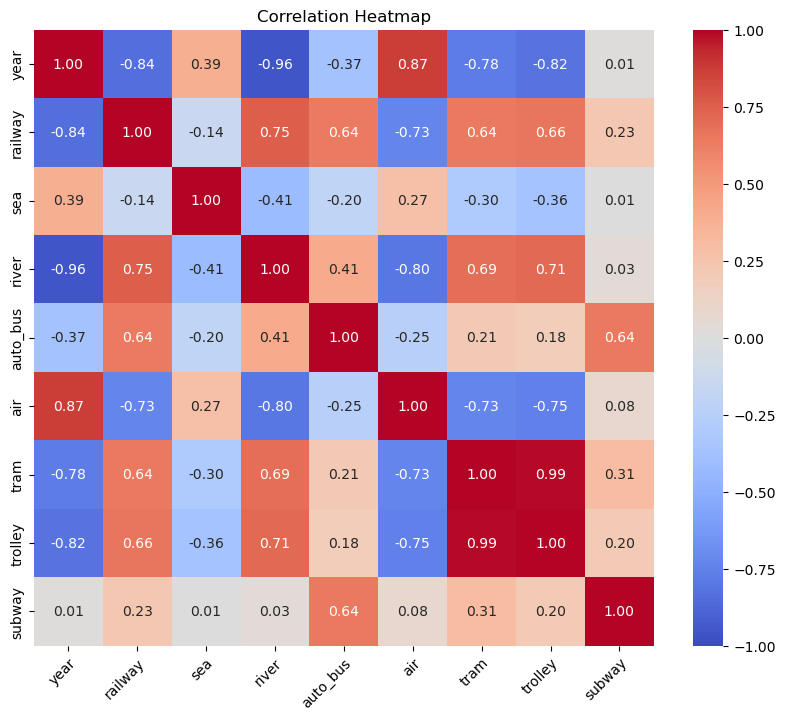

In [12]:
# Observe possible correlations
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot = True, cmap='coolwarm', vmin=-1.0, fmt=".2f")
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.title('Correlation Heatmap')
plt.savefig(os.path.join('Fig', 'correlation matrix.png'))  
plt.show()

## Overview

The correlation matrix provided reveals the relationships between different modes of transportation over a specified period (years). Each value in the matrix indicates the strength and direction of the linear relationship between pairs of transportation modes, with values ranging from -1 to 1. A value closer to 1 indicates a strong positive correlation, while a value closer to -1 indicates a strong negative correlation. A value close to 0 indikates the lack of correlation.

## Key Findings

1. **Strong Inverse Relationships**: 
   - **Year** shows a strong negative correlation with **railway** (-0.94), **sea**(-0.93), and **air** (-0.99) indicating that as the years progress, reliance on these modes may be decreasing.
   - Likewise, a substantial negative correlation exists between **auto_bus** and **year**, and **river** and **year** (-0.89).


2. **Strong Positive Correlations**:

   - **Year** shows a strong positive correlation with **trolley**(0.95) and **tram**(0.93), suggesting that as the years progress, the importance of these types of transportation can increase.
   - There are strong positive correlations among the various public transportation modes such as **railway**, **sea**, **river**, **auto_bus**, and **air**. For instance, **sea** and **river** have a correlation of 0.9, suggesting a strong relationship between these two modes. 
   - The correlation between **tram** and **trolley** is also notably strong at 0.987.

4. **Moderate Correlations**:
   - **Subway** shows moderate correlations with other transportation types but does not exhibit the same strong inverse relationships as seen with **railway** or **air**.

5. **Potential Implications**:
   - The observed trends may imply a shift in transportation preferences over time, possibly influenced by urban development and policy changes favoring more sustainable or efficient modes.

## Conclusion

The correlation analysis of different transportation modes highlights significant trends and relationships, suggesting not only connectivity among various modes but also a potential evolution in transportation preferences over time. These findings can guide future research, urban planning, and investment into transport infrastructure to better align with observed patterns.
